In [1]:
import pandas as pd
data = pd.read_csv("datalab/37964/date_label.csv") 

In [6]:
data.head()

,report_date,total_purchase_amt,total_redeem_amt
0,20130701,32488348,5525022
1,20130702,29037390,2554548
2,20130703,27270770,5953867
3,20130704,18321185,6410729
4,20130705,11648749,2763587


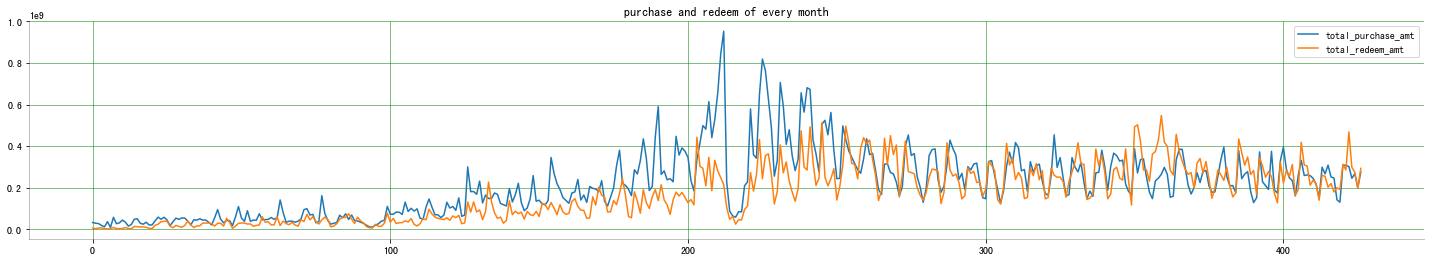

In [7]:
import pandas
import matplotlib.pyplot as plt
data = pandas.read_csv("datalab/37964/date_label.csv")

plt.rcParams['figure.figsize'] = (25, 4.0)  # set figure size

data[['total_purchase_amt', 'total_redeem_amt']].plot()
plt.grid(True, linestyle="-", color="green", linewidth="0.5")
plt.legend()
plt.title('purchase and redeem of every month')

plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.3)

plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 1, 64)             26880     
_________________________________________________________________
lstm_34 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_34 (Dense)             (None, 30)                990       
Total params: 41,342
Trainable params: 41,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
 - 4s - loss: 0.0648
Epoch 2/150
 - 0s - loss: 0.0233
Epoch 3/150
 - 0s - loss: 0.0175
Epoch 4/150
 - 0s - loss: 0.0169
Epoch 5/150
 - 0s - loss: 0.0165
Epoch 6/150
 - 0s - loss: 0.0161
Epoch 7/150
 - 0s - loss: 0.0158
Epoch 8/150
 - 0s - loss: 0.0153
Epoch 

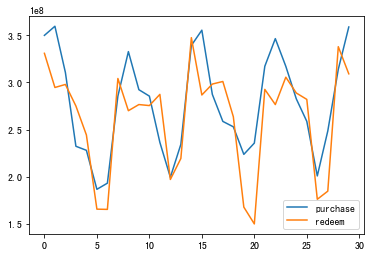

In [12]:
import math
import numpy
import pandas
from keras.layers import LSTM, RNN, GRU, SimpleRNN
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import os

numpy.random.seed(2019)


class LSTMModel(object):
    def __init__(self, look_back=1, epochs_purchase=20, epochs_redeem=40, batch_size=1, verbose=2, patience=10, store_result=False):
        self.look_back = look_back
        self.epochs_purchase = epochs_purchase
        self.epochs_redeem = epochs_redeem
        self.batch_size = batch_size
        self.verbose = verbose
        self.store_result = store_result
        self.patience = patience
        self.purchase = pandas.read_csv("datalab/37964/date_label.csv", usecols=[1], engine='python') 
        self.redeem = pandas.read_csv("datalab/37964/date_label.csv",usecols=[2], engine='python')
        
    def access_data(self, data_frame):
        # load the data set
        data_set = data_frame.values
        data_set = data_set.astype('float32')

        # LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_set = scaler.fit_transform(data_set)

        # reshape into X=t and Y=t+1
        train_x, train_y, test = self.create_data_set(data_set)

        # reshape input to be [samples, time steps, features]
        train_x = numpy.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
        return train_x, train_y, test, scaler

    # convert an array of values into a data set matrix
    def create_data_set(self, data_set):
        data_x, data_y = [], []
        for i in range(len(data_set)-self.look_back - 30):
            a = data_set[i:(i + self.look_back), 0]
            data_x.append(a)
            data_y.append(list(data_set[i + self.look_back: i + self.look_back + 30, 0]))
        # print(numpy.array(data_y).shape)
        return numpy.array(data_x), numpy.array(data_y), data_set[-self.look_back:, 0].reshape(1, 1, self.look_back)

    def rnn_model(self, train_x, train_y, epochs):
        model = Sequential()
        model.add(LSTM(64, input_shape=(1, self.look_back), return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dense(32))
        model.add(Dense(30))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.summary()
        early_stopping = EarlyStopping('loss', patience=self.patience)
        history = model.fit(train_x, train_y, epochs=epochs, batch_size=self.batch_size, verbose=self.verbose, callbacks=[early_stopping])
        return model

    def predict(self, model, data):
        prediction = model.predict(data)
        return prediction

    def plot_show(self, predict):
        predict = predict[['purchase', 'redeem']]
        predict.plot()
        plt.show()

    def run(self):
        purchase_train_x, purchase_train_y, purchase_test, purchase_scaler = self.access_data(self.purchase)
        redeem_train_x, redeem_train_y, redeem_test, redeem_scaler = self.access_data(self.redeem)

        purchase_model = self.rnn_model(purchase_train_x, purchase_train_y, self.epochs_purchase)
        redeem_model = self.rnn_model(redeem_train_x, redeem_train_y, self.epochs_redeem)

        purchase_predict = self.predict(purchase_model, purchase_test)
        redeem_predict = self.predict(redeem_model, redeem_test)

        test_user = pandas.DataFrame({'report_date': [20140900 + i for i in range(1, 31)]})

        purchase = purchase_scaler.inverse_transform(purchase_predict).reshape(30, 1)
        redeem = redeem_scaler.inverse_transform(redeem_predict).reshape(30, 1)

        test_user['purchase'] = purchase
        test_user['redeem'] = redeem
        print(test_user)

        """Store submit file"""
        if self.store_result is True:
            test_user.to_csv('/home/tianchi/myspace/mayiLSTM/submit_lstm.csv', encoding='utf-8', index=None, header=None)
            
        """plot result picture"""
        self.plot_show(test_user)
        
if __name__ == '__main__':
    initiation = LSTMModel(look_back=40, epochs_purchase=150, epochs_redeem=230, batch_size=16, verbose=2, patience=50, store_result=True)
    initiation.run()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 64)             26880     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 30)                990       
Total params: 41,342
Trainable params: 41,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
 - 1s - loss: 0.0654
Epoch 2/150
 - 0s - loss: 0.0241
Epoch 3/150
 - 0s - loss: 0.0173
Epoch 4/150
 - 0s - loss: 0.0167
Epoch 5/150
 - 0s - loss: 0.0165
Epoch 6/150
 - 0s - loss: 0.0159
Epoch 7/150
 - 0s - loss: 0.0155
Epoch 8/150
 - 0s - loss: 0.0150
Epoch 

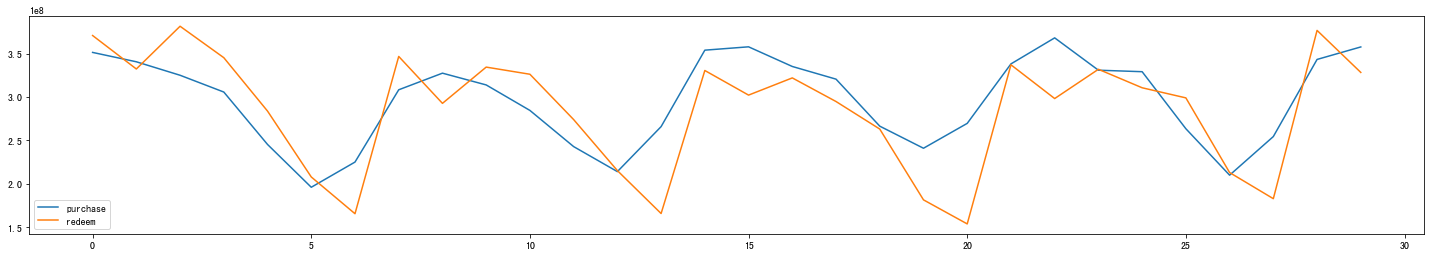

In [9]:
initiation1 = LSTMModel(look_back=40, epochs_purchase=150, epochs_redeem=280, batch_size=16, verbose=2, patience=50, store_result=False)
initiation1.run()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 64)             29440     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                990       
Total params: 43,902
Trainable params: 43,902
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
 - 2s - loss: 0.0677
Epoch 2/150
 - 0s - loss: 0.0232
Epoch 3/150
 - 0s - loss: 0.0181
Epoch 4/150
 - 0s - loss: 0.0174
Epoch 5/150
 - 0s - loss: 0.0169
Epoch 6/150
 - 0s - loss: 0.0164
Epoch 7/150
 - 0s - loss: 0.0157
Epoch 8/150
 - 0s - loss: 0.0151
Epoch 

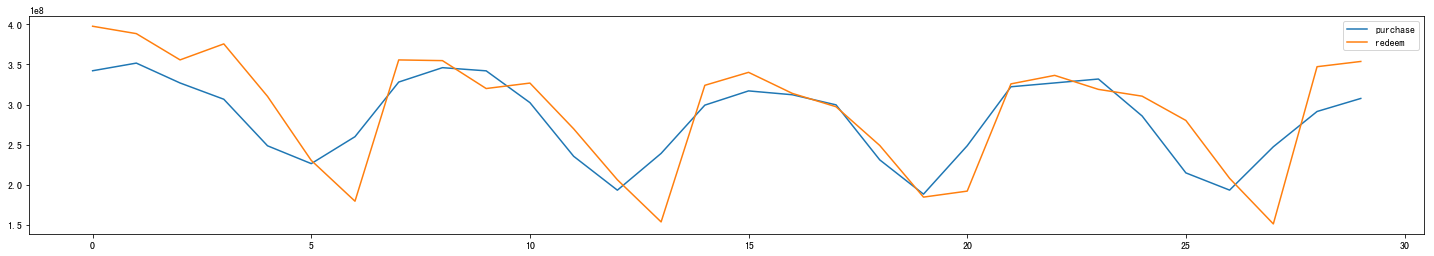

In [10]:
initiation2 = LSTMModel(look_back=50, epochs_purchase=150, epochs_redeem=230, batch_size=16, verbose=2, patience=50, store_result=False)
initiation2.run()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 64)             26880     
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 30)                990       
Total params: 41,342
Trainable params: 41,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/170
 - 2s - loss: 0.0678
Epoch 2/170
 - 0s - loss: 0.0288
Epoch 3/170
 - 0s - loss: 0.0183
Epoch 4/170
 - 0s - loss: 0.0173
Epoch 5/170
 - 0s - loss: 0.0168
Epoch 6/170
 - 0s - loss: 0.0162
Epoch 7/170
 - 0s - loss: 0.0158
Epoch 8/170
 - 0s - loss: 0.0152
Epoch 

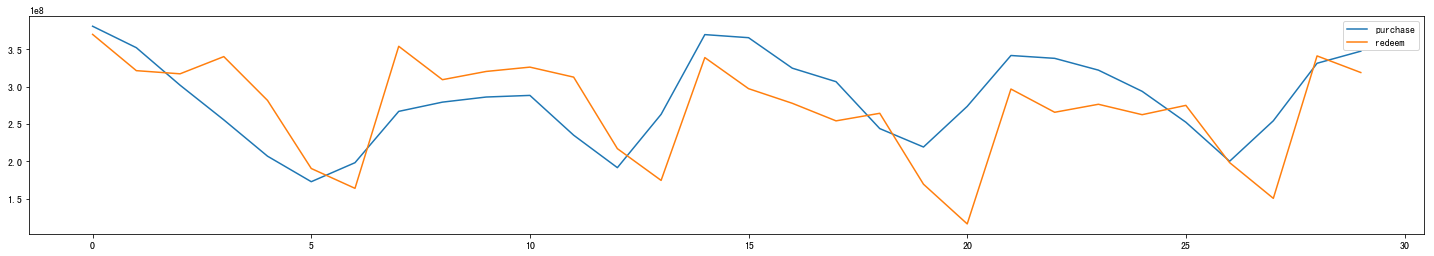

In [11]:
initiation2 = LSTMModel(look_back=40, epochs_purchase=170, epochs_redeem=230, batch_size=16, verbose=2, patience=50, store_result=False)
initiation2.run()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 1, 64)             32000     
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 30)                990       
Total params: 46,462
Trainable params: 46,462
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
 - 2s - loss: 0.0669
Epoch 2/150
 - 0s - loss: 0.0278
Epoch 3/150
 - 0s - loss: 0.0188
Epoch 4/150
 - 0s - loss: 0.0176
Epoch 5/150
 - 0s - loss: 0.0169
Epoch 6/150
 - 0s - loss: 0.0161
Epoch 7/150
 - 0s - loss: 0.0154
Epoch 8/150
 - 0s - loss: 0.0158
Epoch 

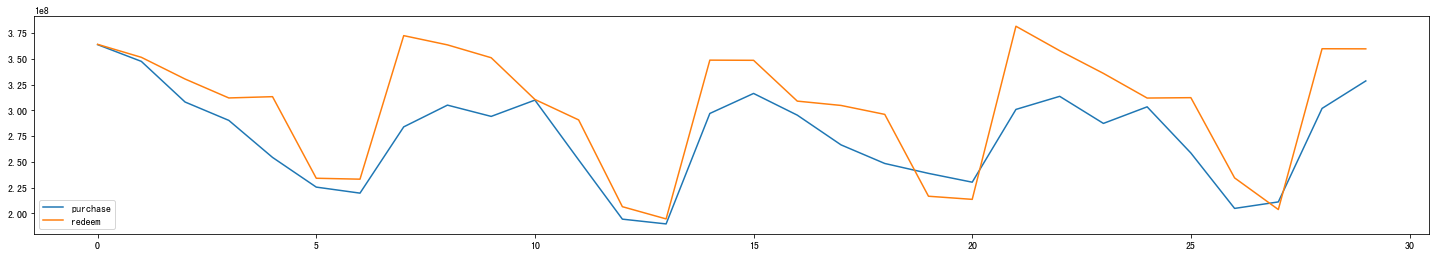

In [12]:
initiation2 = LSTMModel(look_back=60, epochs_purchase=150, epochs_redeem=230, batch_size=16, verbose=2, patience=50, store_result=False)
initiation2.run()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 1, 64)             24320     
_________________________________________________________________
lstm_38 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_38 (Dense)             (None, 30)                990       
Total params: 38,782
Trainable params: 38,782
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
 - 4s - loss: 0.0652
Epoch 2/120
 - 0s - loss: 0.0248
Epoch 3/120
 - 0s - loss: 0.0169
Epoch 4/120
 - 0s - loss: 0.0164
Epoch 5/120
 - 0s - loss: 0.0159
Epoch 6/120
 - 0s - loss: 0.0156
Epoch 7/120
 - 0s - loss: 0.0155
Epoch 8/120
 - 0s - loss: 0.0153
Epoch 

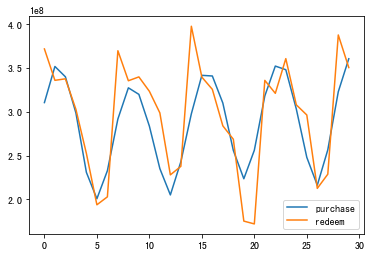

In [13]:
initiation3 = LSTMModel(look_back=30, epochs_purchase=120, epochs_redeem=230, batch_size=16, verbose=2, patience=50, store_result=True)
initiation3.run()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 1, 64)             29440     
_________________________________________________________________
lstm_42 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_42 (Dense)             (None, 30)                990       
Total params: 43,902
Trainable params: 43,902
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
 - 4s - loss: 0.0679
Epoch 2/150
 - 0s - loss: 0.0256
Epoch 3/150
 - 0s - loss: 0.0182
Epoch 4/150
 - 0s - loss: 0.0174
Epoch 5/150
 - 0s - loss: 0.0170
Epoch 6/150
 - 0s - loss: 0.0162
Epoch 7/150
 - 0s - loss: 0.0155
Epoch 8/150
 - 0s - loss: 0.0150
Epoch 

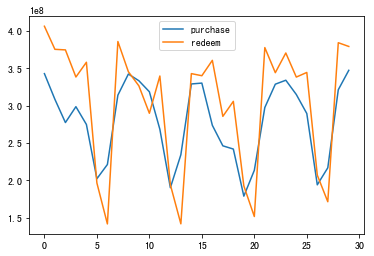

In [14]:
initiation3 = LSTMModel(look_back=50, epochs_purchase=150, epochs_redeem=250, batch_size=16, verbose=2, patience=50, store_result=True)
initiation3.run()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 1, 64)             29440     
_________________________________________________________________
lstm_46 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_45 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_46 (Dense)             (None, 30)                990       
Total params: 43,902
Trainable params: 43,902
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
 - 5s - loss: 0.0700
Epoch 2/150
 - 0s - loss: 0.0264
Epoch 3/150
 - 0s - loss: 0.0181
Epoch 4/150
 - 0s - loss: 0.0175
Epoch 5/150
 - 0s - loss: 0.0169
Epoch 6/150
 - 0s - loss: 0.0164
Epoch 7/150
 - 0s - loss: 0.0158
Epoch 8/150
 - 0s - loss: 0.0154
Epoch 

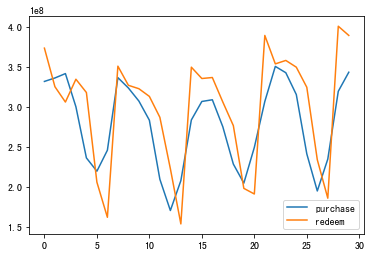

In [15]:
initiation3 = LSTMModel(look_back=50, epochs_purchase=150, epochs_redeem=280, batch_size=16, verbose=2, patience=50, store_result=True)
initiation3.run()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 1, 64)             30720     
_________________________________________________________________
lstm_50 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_49 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_50 (Dense)             (None, 30)                990       
Total params: 45,182
Trainable params: 45,182
Non-trainable params: 0
_________________________________________________________________
Epoch 1/160
 - 5s - loss: 0.0663
Epoch 2/160
 - 0s - loss: 0.0244
Epoch 3/160
 - 0s - loss: 0.0183
Epoch 4/160
 - 0s - loss: 0.0174
Epoch 5/160
 - 0s - loss: 0.0169
Epoch 6/160
 - 0s - loss: 0.0166
Epoch 7/160
 - 0s - loss: 0.0158
Epoch 8/160
 - 0s - loss: 0.0152
Epoch 

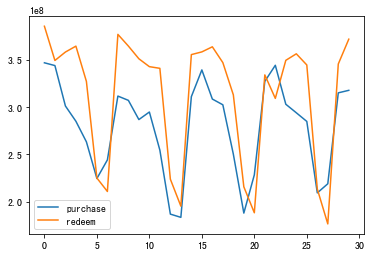

In [16]:
initiation3 = LSTMModel(look_back=55, epochs_purchase=160, epochs_redeem=280, batch_size=16, verbose=2, patience=50, store_result=True)
initiation3.run()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 1, 64)             26880     
_________________________________________________________________
lstm_54 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_54 (Dense)             (None, 30)                990       
Total params: 41,342
Trainable params: 41,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
 - 6s - loss: 0.0721
Epoch 2/120
 - 0s - loss: 0.0264
Epoch 3/120
 - 0s - loss: 0.0178
Epoch 4/120
 - 0s - loss: 0.0171
Epoch 5/120
 - 0s - loss: 0.0167
Epoch 6/120
 - 0s - loss: 0.0162
Epoch 7/120
 - 0s - loss: 0.0157
Epoch 8/120
 - 0s - loss: 0.0153
Epoch 

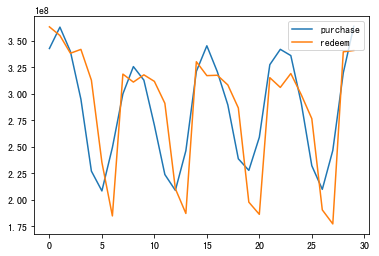

In [17]:
initiation3 = LSTMModel(look_back=40, epochs_purchase=120, epochs_redeem=210, batch_size=16, verbose=2, patience=50, store_result=True)
initiation3.run()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 1, 64)             26880     
_________________________________________________________________
lstm_62 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_61 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_62 (Dense)             (None, 30)                990       
Total params: 41,342
Trainable params: 41,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
 - 6s - loss: 0.0596
Epoch 2/150
 - 0s - loss: 0.0228
Epoch 3/150
 - 0s - loss: 0.0174
Epoch 4/150
 - 0s - loss: 0.0168
Epoch 5/150
 - 0s - loss: 0.0165
Epoch 6/150
 - 0s - loss: 0.0162
Epoch 7/150
 - 0s - loss: 0.0158
Epoch 8/150
 - 0s - loss: 0.0154
Epoch 

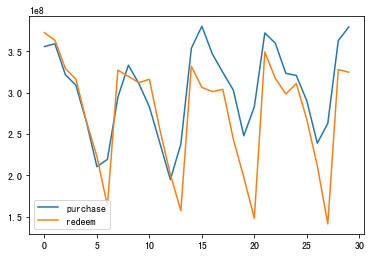

In [19]:
initiation1 = LSTMModel(look_back=40, epochs_purchase=150, epochs_redeem=280, batch_size=16, verbose=2, patience=50, store_result=True)
initiation1.run()